In [45]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Files

In [46]:
dataset = 'model/keypoint_classifier/right_keypoint.csv'
model_save_path = 'model/keypoint_classifier/model/right_classifier.keras'

# Number of classes

In [47]:
NUM_CLASSES = 34

# Load dataset

In [48]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21*2) +1 +4)))

In [49]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Define Machine Learning Model Approach

In [51]:
from tensorflow.keras.layers import Input, Reshape, MultiHeadAttention, LayerNormalization, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

keypoint_input_shape = (21, 2)
global_input_shape = (4,) 

keypoints_input = Input(shape=(21 * 2,))
global_features_input = Input(shape=(4,))

keypoints_reshaped = Reshape((21, 2))(keypoints_input)

attention_output = MultiHeadAttention(num_heads=4, key_dim=2)(keypoints_reshaped, keypoints_reshaped, keypoints_reshaped)
x = LayerNormalization()(attention_output + keypoints_reshaped)  # Residual Connection

x = Flatten()(x)
x = Concatenate()([x, global_features_input])

x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=[keypoints_input, global_features_input], outputs=outputs)


In [52]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 42)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_3 (Reshape)           │ (None, 21, 2)             │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_3        │ (None, 21, 2)             │              90 │ reshape_3[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ reshape_3[0][0],           │
│                               │                           │                 │ reshape_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 21, 2)             │               0 │ multi_head_attention_3[0]… │
│                               │                           │                 │ reshape_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_3         │ (None, 21, 2)             │               4 │ add_3[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_3 (Flatten)           │ (None, 42)                │               0 │ layer_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_7 (InputLayer)    │ (None, 4)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 46)                │               0 │ flatten_3[0][0],           │
│                               │                           │                 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 64)                │           3,008 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 64)                │               0 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 32)                │           2,080 │ dropout_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 34)                │           1,122 │ dense_10[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 6,304 (24.62 KB)

 Trainable params: 6,304 (24.62 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [54]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Split inputs into keypoints and global features (distance of fingertips from one another)

In [55]:
# Split X_train and X_test into two separate inputs
X_train_keypoints = X_train[:, :21*2]   # First 42 columns → keypoints
X_train_global = X_train[:, 21*2:]      # Last 4 columns → global features

X_test_keypoints = X_test[:, :21*2]
X_test_global = X_test[:, 21*2:]

# Now pass them as separate inputs
model.fit(
    [X_train_keypoints, X_train_global],  # Two inputs
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=([X_test_keypoints, X_test_global], y_test),
    callbacks=[cp_callback, es_callback]
)


Epoch 1/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0627 - loss: 3.4785
Epoch 1: saving model to model/keypoint_classifier/model/right_classifier.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.0630 - loss: 3.4767 - val_accuracy: 0.2266 - val_loss: 2.9100
Epoch 2/1000
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2041 - loss: 2.7843  
Epoch 2: saving model to model/keypoint_classifier/model/right_classifier.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2044 - loss: 2.7826 - val_accuracy: 0.3841 - val_loss: 2.0924
Epoch 3/1000
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3372 - loss: 2.0610
Epoch 3: saving model to model/keypoint_classifier/model/right_classifier.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3391 - loss: 2.0541 - val_accuracy: 0.5795 - val_loss: 1.3759
Epoch 4/1000
 97/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5057 - loss: 1.4685
Epoch 4: saving model to model/keypoint_classifi

In [56]:
# Split X_test into two inputs
X_test_keypoints = X_test[:, :21*2]  # First 42 columns → keypoints
X_test_global = X_test[:, 21*2:]     # Last 4 columns → global features

# Evaluate the model with the two inputs
val_loss, val_acc = model.evaluate([X_test_keypoints, X_test_global], y_test, batch_size=128)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9795 - loss: 0.0777


In [57]:
model = tf.keras.models.load_model(model_save_path)

In [58]:
# Split X_test[0] into two separate inputs
X_test_keypoints = X_test[0, :21*2].reshape(1, -1)  # First 42 values → keypoints
X_test_global = X_test[0, 21*2:].reshape(1, -1)    # Last 4 values → global features

# Perform inference using both inputs
predict_result = model.predict([X_test_keypoints, X_test_global])

# Process and print results
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
[0.0000000e+00 1.8578417e-18 6.7656247e-32 2.4839469e-23 1.2816331e-25
 1.2666079e-28 7.2159231e-14 2.7992315e-14 1.2345644e-22 2.5331838e-20
 7.2407886e-08 1.0541791e-12 5.6385530e-30 2.1890729e-18 1.2743068e-16
 2.8847787e-26 9.2030362e-08 8.3918249e-19 1.5011091e-26 5.9639182e-35
 6.5925343e-24 0.0000000e+00 2.2837479e-32 8.9667665e-30 4.6064394e-32
 6.1820202e-16 4.7081116e-24 1.4313755e-13 9.9999022e-01 1.5041171e-20
 2.1940157e-16 2.8301025e-20 3.2296750e-20 9.5066889e-06]
28


# Evaluate

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   


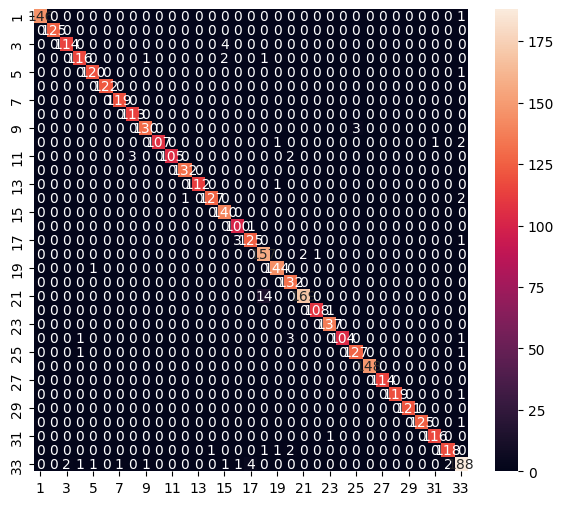

Classification Report
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       147
           2       1.00      1.00      1.00       125
           3       0.98      0.97      0.97       118
           4       0.97      0.97      0.97       120
           5       0.98      0.99      0.99       121
           6       1.00      1.00      1.00       122
           7       0.99      1.00      1.00       119
           8       0.97      1.00      0.99       113
           9       0.98      0.98      0.98       133
          10       1.00      0.96      0.98       111
          11       1.00      0.95      0.98       110
          12       0.99      1.00      1.00       132
          13       1.00      0.99      1.00       113
          14       0.99      0.98      0.98       130
          15       0.95      1.00      0.98       140
          16       0.96      0.99      0.98       101
          17       0.96      0.97      0.97       129
     

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict([X_test[:, :21*2], X_test[:, 21*2:]])  # Split into two inputs
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to TensorFlow Lite

In [60]:
model.save(model_save_path, include_optimizer=False)

In [61]:
tflite_save_path = 'model/keypoint_classifier/model/right_keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\harold\AppData\Local\Temp\tmpbi0x9_nf\assets


INFO:tensorflow:Assets written to: C:\Users\harold\AppData\Local\Temp\tmpbi0x9_nf\assets


Saved artifact at 'C:\Users\harold\AppData\Local\Temp\tmpbi0x9_nf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_6'), TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_layer_7')]
Output Type:
  TensorSpec(shape=(None, 34), dtype=tf.float32, name=None)
Captures:
  2651778615632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2651778618320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2651778615824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2651778618704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2651778618896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2651778617552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2651778618128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2651778617744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2651778617360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2651

20448

# Define input

In [62]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
print("TFLite expected input shape:", input_details[0]['shape'])

TFLite expected input shape: [ 1 42]


In [63]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [64]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0, :21*2]]))  # Keypoints
interpreter.set_tensor(input_details[1]['index'], np.array([X_test[0, 21*2:]]))  # Global features

In [65]:
%%time
# Run inference
interpreter.invoke()

# Get output
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print("Model input shape:", model.input_shape)

Model input shape: [(None, 42), (None, 4)]
CPU times: total: 0 ns
Wall time: 1.26 ms


In [66]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.00000000e+00 1.28358734e-18 6.33573176e-32 2.04151286e-23
 1.70652690e-25 9.25188097e-29 5.28416659e-14 2.09007904e-14
 7.44427778e-23 1.84644694e-20 6.58233290e-08 8.06742206e-13
 4.31173999e-30 1.73870511e-18 1.07695514e-16 2.85261070e-26
 9.22239920e-08 7.39848641e-19 1.13015433e-26 3.96257051e-35
 4.04838526e-24 0.00000000e+00 1.81729619e-32 5.71491687e-30
 3.61470390e-32 3.88251263e-16 3.44808341e-24 8.90484992e-14
 9.99992013e-01 1.17633985e-20 1.59356252e-16 2.16823054e-20
 2.21411790e-20 7.72427666e-06]
28
